# Inroduction

We would like to design an algorithm to identify physically distinct sources of dust emission along different sight lines. To this end, we use HI emission as a proxy for thermal dust emission. This data identifies emission on the whole sky as a function of velocity, which can be treated as a third dimension probing distance from the observer.

In order to identify distinct HI *objects* we will apply clustering algorithms to group together clumps of HI emission, both in the plane of the sky, and along the velocity direction, as larger objects can be coherent across multiple velocity channels. 

## Different types of clustering

The algorithmic requirements we have are:

* To some extened speed. The data are provided on 41 nside=1024 maps of T, Q, U. This constitues hundreds of millions of pixels, even on smaller sky areas.
* Applicable to map-space, we are ultimately intersetd in image segmentation.
* Ideally not having to specify the number of clusters


Possible algorithms to apply:

* $k$-means: this is the simplest approach of laying down centroids throughout the domain, testing their ability to summarize the data, and iterating their positions based on some penalty criterion.
* Mean-shift clustering (similar but different to $k$-means), which was used in Grumitt et al. This has the advantage of not having to specify the number of clusters.
* Agglomerative clustering: this is an appealing hierarchical approach, which may work well for the 'clumpy' type of emission we see in the Galaxy.

Both of thse are implemented in `scikit-learn`.

### Hierarchical DBSCAN

HDBSCAN is a density-based clustering algorithm which satistifes the following attractive properties:

* Inidfferent to the shape of clusters ($k$-means and GMM both fundamentally assume spherical / ellipsoidal distributions).
* Does not require the number of clusters to be specified.
* Robust with respect to the density of clusters.
* Only one hyperparameter, which specifies the minimum number of points in a cluster.
* For each cell it reports probability of assignment to a cluster, this allows penalization of unassigned cells, which in turn allows optimization of the minimum size of clusters.

## Gotchas

Some things to look out for as the analysis progresses:

* High-dimensionl clustering: distance measures in dimensions higher than three can become counterintuitive. May need to think more carefully about how to calculate the distance between points (e.g. LASSO).
* Determination of number of clusters is ambiguous. Heriarchical and $k$-means need to be carefully compared.
* Clustering can be an unstable analysis, difficult to reproduce.

## Example comparison between different methods

In [5]:
import time
import h5py

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

import hdbscan

import matplotlib
import matplotlib.cm
from matplotlib.colors import LinearSegmentedColormap
import cycler
import cosmoplotian.projections
import cosmoplotian.colormaps

def set_color_cycle(name, nlines=5):
    cmap = plt.cm.get_cmap(name)
    colors = cmap(np.linspace(0, 1, nlines)[::-1])
    matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', colors)

In [6]:
plt.style.use('default')
plt.rcParams['text.usetex'] = True

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times', 'Palatino', 'New Century Schoolbook', 'Bookman', 'Computer Modern Roman']

set_color_cycle('div yel grn')

/global/homes/b/bthorne/anaconda3/envs/h1/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)
/global/homes/b/bthorne/anaconda3/envs/h1/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)
/global/homes/b/bthorne/anaconda3/envs/h1/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting fro

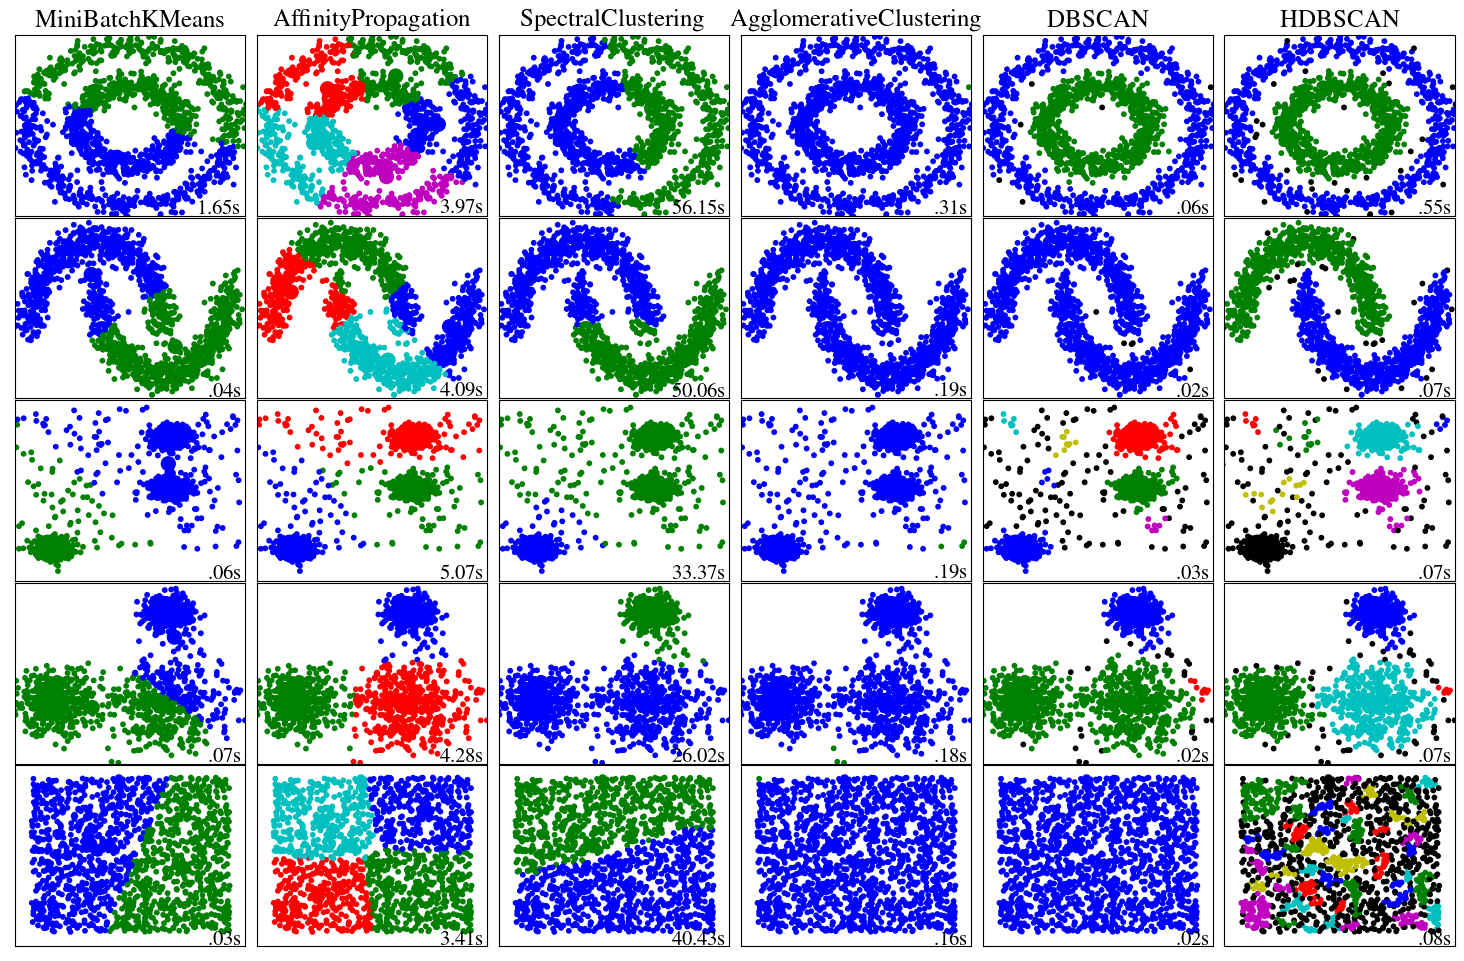

In [56]:
np.random.seed(0)
def make_var_density_blobs(n_samples=750, centers=[[0,0]], cluster_std=[0.5], random_state=0):
    samples_per_blob = n_samples // len(centers)
    blobs = [datasets.make_blobs(n_samples=samples_per_blob, centers=[c], cluster_std=cluster_std[i])[0]
             for i, c in enumerate(centers)]
    labels = [i * np.ones(samples_per_blob) for i in range(len(centers))]
    return np.vstack(blobs), np.hstack(labels)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.08)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.10)
blobs = datasets.make_blobs(n_samples=n_samples-200, random_state=8)
noisy_blobs = np.vstack((blobs[0], 25.0*np.random.rand(200, 2)-[10.0,10.0])), np.hstack((blobs[1], -1*np.ones(200))) 
varying_blobs = make_var_density_blobs(n_samples,
                                       centers=[[1, 1],
                                                [-1, -1],
                                                [1, -1]],
                                       cluster_std=[0.2, 0.35, 0.5])
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation',
    'SpectralClustering', 'AgglomerativeClustering',
    'DBSCAN', 'HDBSCAN']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, noisy_blobs, varying_blobs, no_structure]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    hdbscanner = hdbscan.HDBSCAN()
    clustering_algorithms = [
        two_means, affinity_propagation, spectral, average_linkage,
        dbscan, hdbscanner]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(5, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Data preparation

First we need to decide on the data we will use, and prepare it for the application of the different clustering algorithms we want to test.

This method will eventually be applied to multi-veloctiy observations, however we being by applying it to the total integrated HI emission maps.

## Read in $I_{\rm HI}$ and $\beta_d$

In [64]:
nside = 64

In [65]:
from pathlib import Path
import requests
import os

import cosmoplotian.projections
import cosmoplotian

from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic, ICRS
import ligo.skymap.plot

import ipywidgets as widgets

import numpy as np
import healpy as hp
import numpy.ma as ma

In [70]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1agsFlxGlUFhWQSKMqRqml8Y5L4YrxiyE' -O- | sed -rn  's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1agsFlxGlUFhWQSKMqRqml8Y5L4YrxiyE" -O $SCRATCH/h1/premise_beta.fits && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hKRwCeksKRevm_2Z6VDM0rfyWY2VFKmB' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hKRwCeksKRevm_2Z6VDM0rfyWY2VFKmB" -O $SCRATCH/h1/premise_temp.fits && rm -rf /tmp/cookies.txt

--2020-08-10 15:24:56--  https://docs.google.com/uc?export=download&confirm=8Q2E&id=1agsFlxGlUFhWQSKMqRqml8Y5L4YrxiyE
Resolving docs.google.com (docs.google.com)... 2607:f8b0:4009:804::200e, 172.217.4.46
Connecting to docs.google.com (docs.google.com)|2607:f8b0:4009:804::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-0o-docs.googleusercontent.com/docs/securesc/numb2b38n398qbobkbr6keh87i2basjs/l7s17uqiej5ijm5clcqi2j43n8mc42ti/1597098225000/09747581623206617688/16276273644260564565Z/1agsFlxGlUFhWQSKMqRqml8Y5L4YrxiyE?e=download [following]
--2020-08-10 15:24:56--  https://doc-08-0o-docs.googleusercontent.com/docs/securesc/numb2b38n398qbobkbr6keh87i2basjs/l7s17uqiej5ijm5clcqi2j43n8mc42ti/1597098225000/09747581623206617688/16276273644260564565Z/1agsFlxGlUFhWQSKMqRqml8Y5L4YrxiyE?e=download
Resolving doc-08-0o-docs.googleusercontent.com (doc-08-0o-docs.googleusercontent.com)... 2607:f8b0:4009:80e::2001, 216.58.192.193
Connecting 

In [71]:
root = Path(os.environ["SCRATCH"]) / "h1"
root.mkdir(exist_ok=True)

downloads = [
    ("IQU_integrated_HI4PI_Kkms.fits", 
     "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/P41KDE/DLAMEB"
    ),
    ("premise_beta.fits",
    None
    ),
    ("premise_temp.fits",
    None
    ),
    ("I_v_HI4PI_Kkms.h5",
     "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/P41KDE/KT7PV4"
    ),
    ("HI4PI_startvels.npy",
     "https://github.com/seclark/ClarkHensley2019/raw/master/data/HI4PI_startvels.npy"
    ),
    ("HI4PI_stopvels.npy",
     "https://github.com/seclark/ClarkHensley2019/raw/master/data/HI4PI_stopvels.npy"
    ),
]

for fname, url in downloads:
    if url is None:
        continue
    save_path = root / fname
    if save_path.exists():
        print(f"File {save_path} already exists, not downloading.")
        continue
    else:
        print(f"Downloading to {save_path}.")
        req = requests.get(url, stream=True, allow_redirects=True)
        with open(save_path, 'wb') as f:
            for chunk in req.iter_content(8096):
                if chunk:
                    f.write(chunk)

# for convenience store local paths to data files in dictionary
data_paths = {fname: str(root / fname) for fname, _ in downloads}
                            
display(data_paths)

HDU_HI4PI = fits.open(data_paths['IQU_integrated_HI4PI_Kkms.fits'])
display(HDU_HI4PI[1].header)

I_HI4PI = np.nan_to_num(HDU_HI4PI[1].data['IHI'], hp.UNSEEN)
I_HI4PI_256 = hp.ud_grade(I_HI4PI, nside_out=256)

File /global/cscratch1/sd/bthorne/h1/IQU_integrated_HI4PI_Kkms.fits already exists, not downloading.
File /global/cscratch1/sd/bthorne/h1/I_v_HI4PI_Kkms.h5 already exists, not downloading.
File /global/cscratch1/sd/bthorne/h1/HI4PI_startvels.npy already exists, not downloading.
File /global/cscratch1/sd/bthorne/h1/HI4PI_stopvels.npy already exists, not downloading.


{'IQU_integrated_HI4PI_Kkms.fits': '/global/cscratch1/sd/bthorne/h1/IQU_integrated_HI4PI_Kkms.fits',
 'premise_beta.fits': '/global/cscratch1/sd/bthorne/h1/premise_beta.fits',
 'premise_temp.fits': '/global/cscratch1/sd/bthorne/h1/premise_temp.fits',
 'I_v_HI4PI_Kkms.h5': '/global/cscratch1/sd/bthorne/h1/I_v_HI4PI_Kkms.h5',
 'HI4PI_startvels.npy': '/global/cscratch1/sd/bthorne/h1/HI4PI_startvels.npy',
 'HI4PI_stopvels.npy': '/global/cscratch1/sd/bthorne/h1/HI4PI_stopvels.npy'}

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   12 / length of dimension 1                          
NAXIS2  =             12582912 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'IHI     '                                                            
TFORM1  = 'E       '                                                            
TUNIT1  = 'K km/s  '                                                            
TTYPE2  = 'QHI     '                                                            
TFORM2  = 'E       '        

In [72]:
print('============================= PREMISE BETA FILE HEADER =================================\n')
HDU_PREMISE_BETA = fits.open(data_paths['premise_beta.fits'])
display(HDU_PREMISE_BETA[1].header)
PREMISE_BETA = hp.read_map(data_paths['premise_beta.fits'], verbose=False)
print(PREMISE_BETA.shape)
print('\n============================= PREMISE TEMP FILE HEADER =================================\n')
HDU_PREMISE_T = fits.open(data_paths['premise_temp.fits'])
display(HDU_PREMISE_T[1].header)
PREMISE_TEMP = hp.read_map(data_paths['premise_temp.fits'], verbose=False)
print('\n========================================================================================\n')

============================= PREMISE BETA FILE HEADER =================================



XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'I       '                                                            
TFORM1  = '1024E   '                                                            
PIXTYPE = 'HEALPIX '           / HEALPIX pixelisation                           
ORDERING= 'RING    '           / Pixel ordering scheme, either RING or NESTED   
EXTNAME = 'xtension'        

/global/homes/b/bthorne/anaconda3/envs/h1/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


(50331648,)

============================= PREMISE TEMP FILE HEADER =================================



/global/homes/b/bthorne/anaconda3/envs/h1/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'I       '                                                            
TFORM1  = '1024E   '                                                            
PIXTYPE = 'HEALPIX '           / HEALPIX pixelisation                           
ORDERING= 'RING    '           / Pixel ordering scheme, either RING or NESTED   
EXTNAME = 'xtension'        

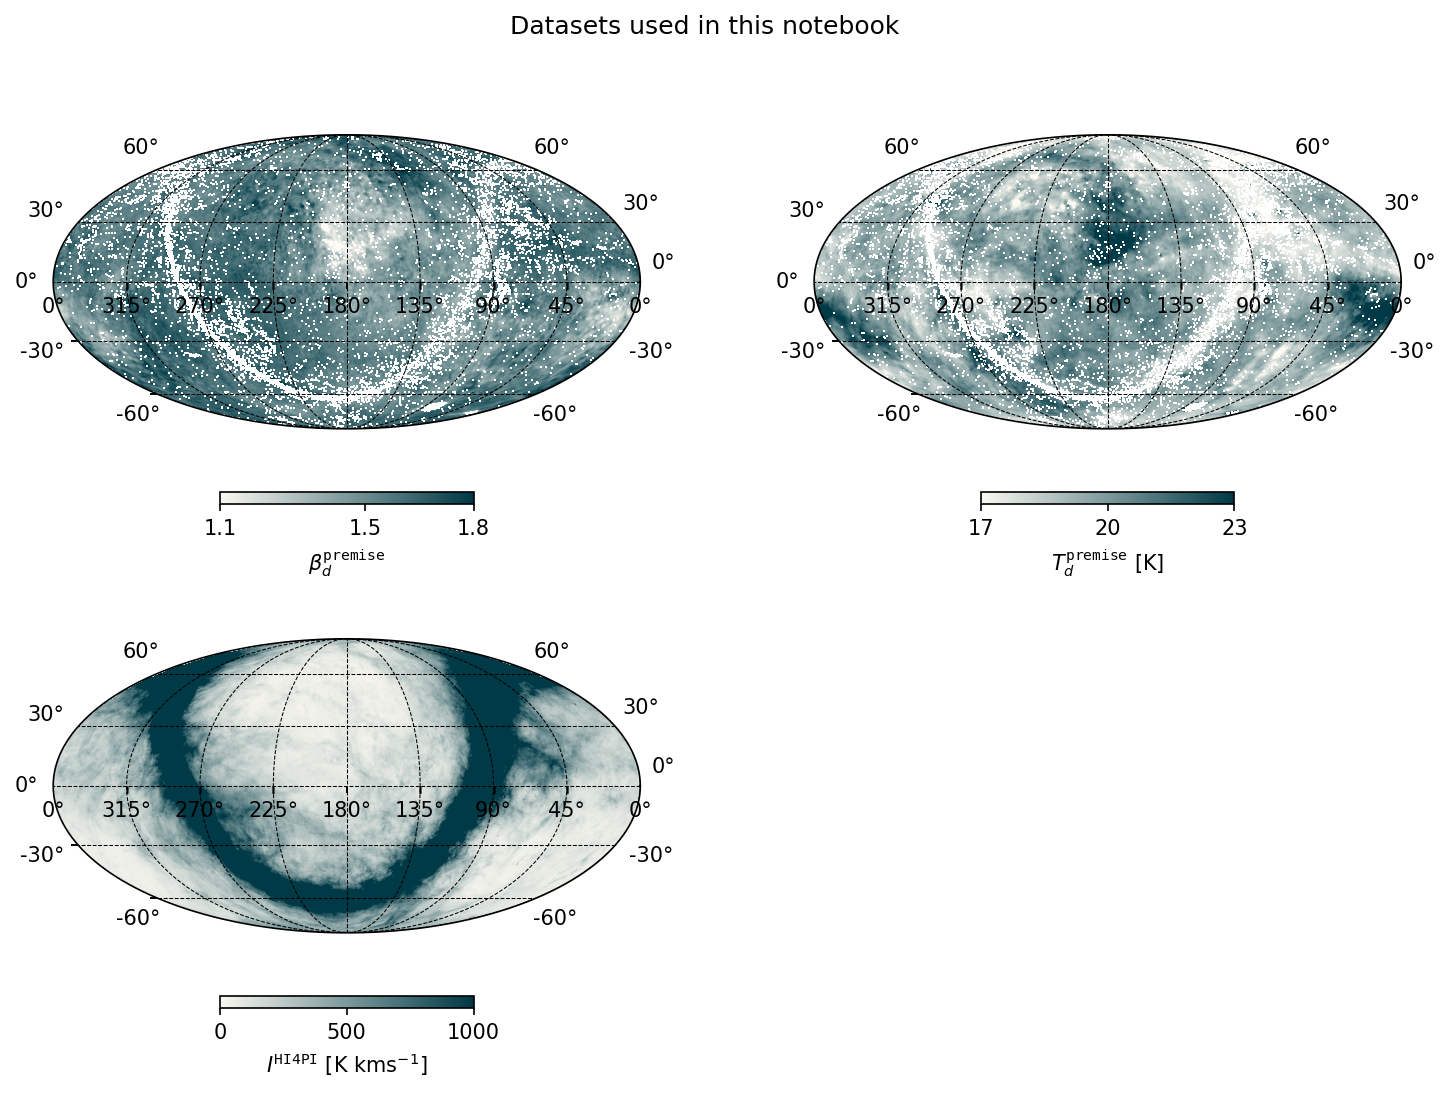

In [73]:
subplot_kw = {
    'projection': 'astro degrees mollweide',
}
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), dpi=150, subplot_kw=subplot_kw)

fig.suptitle(r"Datasets used in this notebook")

# plot the premise dust index map
ax1.grid(linestyle='--', linewidth=0.5, color='k')
img1 = ax1.imshow_hpx((PREMISE_BETA, Galactic()),  cmap='lin blu', vmin=1.1, vmax=1.8)
img1.cmap.set_bad('w', alpha=0)

cb1 = plt.colorbar(img1, orientation='horizontal', shrink=0.4, ax=ax1)
cb1.ax.xaxis.set_ticks([1.1, 1.5, 1.8])
cb1.solids.set_edgecolor('face')
cb1.set_label(r"$\beta_d^{\tt premise}$")

# Plot the premise dust temperature map
ax2.grid(linestyle='--', linewidth=0.5, color='k')
img2 = ax2.imshow_hpx((PREMISE_TEMP, Galactic()),  cmap='lin blu', vmin=17, vmax=23)
img2.cmap.set_bad('w', alpha=0)

cb2 = plt.colorbar(img2, orientation='horizontal', shrink=0.4, ax=ax2)
cb2.ax.xaxis.set_ticks([17, 20, 23])
cb2.solids.set_edgecolor('face')
cb2.set_label(r"$T_d^{\tt premise}~[\rm K]$")

# Plot the premise dust temperature map
ax3.grid(linestyle='--', linewidth=0.5, color='k')
img3 = ax3.imshow_hpx((I_HI4PI, Galactic()),  cmap='lin blu', vmin=0, vmax=1000)
img3.cmap.set_bad('w', alpha=0)

cb3 = plt.colorbar(img3, orientation='horizontal', shrink=0.4, ax=ax3)
cb3.ax.xaxis.set_ticks([0, 500, 1000])
cb3.solids.set_edgecolor('face')
cb3.set_label(r"$I^{\tt HI4PI}~[\rm K~kms^{-1}]$")

ax4.set_visible(False)

## Cut out region at pole

Most of the clustering algorithms we're trying are slow, and so we are working at $n_{\rm side}=256$, and have cut out a region at $(l, b)=(0^\circ, -90^\circ)$.

### Cutout $I_{\rm HI}$ map

In [74]:
center = SkyCoord(l=0. * u.deg, b=90. * u.deg, frame=Galactic()).icrs
radius = 20. * u.deg

In [75]:
npix = hp.nside2npix(nside)
query = hp.query_strip(nside, np.radians(0), np.radians(20))

I_HI4PI_ma = np.ma.masked_all(npix)
I_HI4PI_ma.set_fill_value(np.nan)

I_HI4PI_ma[query] = I_HI4PI_256[query]

### Cutout $\beta_d$ map

In [76]:
npix_premise = hp.nside2npix(2048)

query_premise = hp.query_strip(2048, np.radians(0), np.radians(20))
PREMISE_BETA_ma = np.ma.masked_all(npix_premise)
PREMISE_BETA_ma.set_fill_value(np.nan)
PREMISE_BETA_ma[query_premise] = PREMISE_BETA[query_premise]

PREMISE_TEMP_ma = np.ma.masked_all(npix_premise)
PREMISE_TEMP_ma.set_fill_value(np.nan)
PREMISE_TEMP_ma[query_premise] = PREMISE_TEMP[query_premise]

### Premise spectral index map plots

Here we plot the premise spectral index maps published in [Irfan+'19](https://arxiv.org/abs/1901.01713). 

1. There is clearly anticorrelation on the largest scales between the the two parameters. 
2. There seem to be a lot of point source masks - this is not a problem with the COMMANDER dust maps.

We will look to compare the results of the clustering analysis with the larger scale variation foundin these maps. For now, it might be sensible to downgrade the spectral index maps, using the average values of surrounding pixels to fill in the masks.

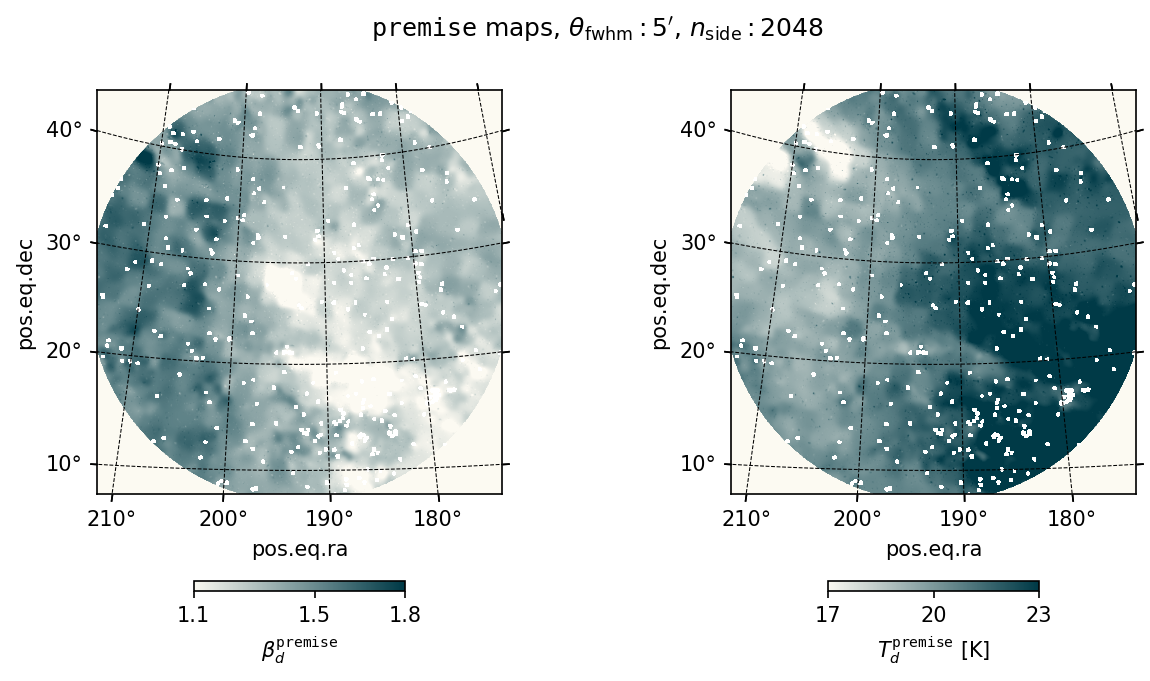

In [77]:
subplot_kw = {
    'projection': 'astro degrees zoom',
    'center': center,
    'radius': radius,
}
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), dpi=150, subplot_kw=subplot_kw)

fig.suptitle(r"${\tt premise}$ maps, $\theta_{\rm fwhm}: 5^\prime$, $n_{\rm side}: 2048$")

# plot the premise dust index map
ax1.grid(linestyle='--', linewidth=0.5, color='k')
img1 = ax1.imshow_hpx((PREMISE_BETA_ma, Galactic()),  cmap='lin blu', vmin=1.1, vmax=1.8)
img1.cmap.set_bad('w', alpha=0)

cb1 = plt.colorbar(img1, orientation='horizontal', shrink=0.4, ax=ax1)
cb1.ax.xaxis.set_ticks([1.1, 1.5, 1.8])
cb1.solids.set_edgecolor('face')
cb1.set_label(r"$\beta_d^{\tt premise}$")

# Plot the premise dust temperature map
ax2.grid(linestyle='--', linewidth=0.5, color='k')
img2 = ax2.imshow_hpx((PREMISE_TEMP_ma, Galactic()),  cmap='lin blu', vmin=17, vmax=23)
img2.cmap.set_bad('w', alpha=0)

cb2 = plt.colorbar(img2, orientation='horizontal', shrink=0.4, ax=ax2)
cb2.ax.xaxis.set_ticks([17, 20, 23])
cb2.solids.set_edgecolor('face')
cb2.set_label(r"$T_d^{\tt premise}~[\rm K]$")

### Filling point source masks

To fill in the missing data we will downgrade to nside 64.

In [78]:
# The missing pixels contain nan values.
np.isnan(PREMISE_TEMP_ma.compressed()).any()

True

In [79]:
# First convert masked region to hp.UNSEEN to cooperate with healpy ud_grade
PREMISE_TEMP_ma.set_fill_value(hp.UNSEEN)
# Convert point source nans to hp.UNSEEN
np.nan_to_num(PREMISE_TEMP_ma, copy=False, nan=hp.UNSEEN)

masked_array(data=[21.944305419921875, 21.939228057861328,
                   21.929378509521484, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-1.6375e+30)

In [80]:
# Now repeat for beta maps
PREMISE_BETA_ma.set_fill_value(hp.UNSEEN)
# Convert point source nans to hp.UNSEEN
np.nan_to_num(PREMISE_BETA_ma, copy=False, nan=hp.UNSEEN)

masked_array(data=[1.065950632095337, 1.071333408355713,
                   1.0755605697631836, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-1.6375e+30)

In [81]:
# Check data region to make sure no nans are present
np.isnan(PREMISE_TEMP_ma.compressed()).any()

False

In [82]:
PREMISE_TEMP_ma_64 = hp.ud_grade(PREMISE_TEMP_ma, nside_out=64)
PREMISE_BETA_ma_64 = hp.ud_grade(PREMISE_BETA_ma, nside_out=64)

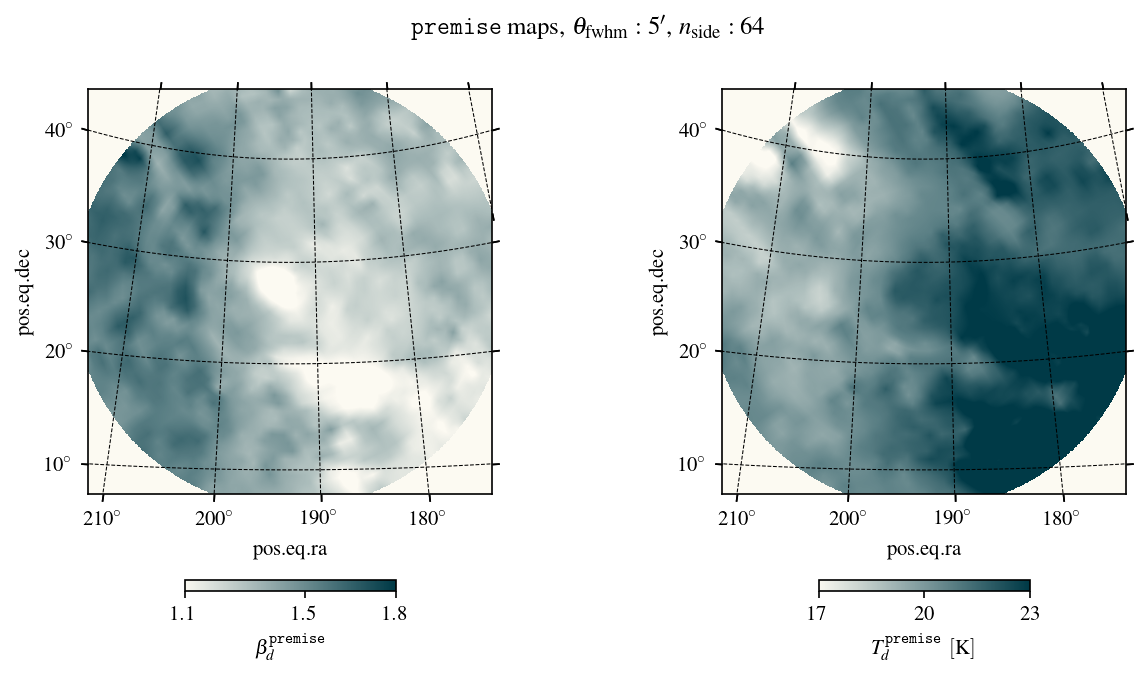

In [73]:
subplot_kw = {
    'projection': 'astro degrees zoom',
    'center': center,
    'radius': radius,
}
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), dpi=150, subplot_kw=subplot_kw)

fig.suptitle(r"${\tt premise}$ maps, $\theta_{\rm fwhm}: 5^\prime$, $n_{\rm side}: 64$")

# plot the premise dust index map
ax1.grid(linestyle='--', linewidth=0.5, color='k')
img1 = ax1.imshow_hpx((PREMISE_BETA_ma_64, Galactic()),  cmap='lin blu', vmin=1.1, vmax=1.8)
img1.cmap.set_bad('w', alpha=0)

cb1 = plt.colorbar(img1, orientation='horizontal', shrink=0.4, ax=ax1)
cb1.ax.xaxis.set_ticks([1.1, 1.5, 1.8])
cb1.solids.set_edgecolor('face')
cb1.set_label(r"$\beta_d^{\tt premise}$")

# Plot the premise dust temperature map
ax2.grid(linestyle='--', linewidth=0.5, color='k')
img2 = ax2.imshow_hpx((PREMISE_TEMP_ma_64, Galactic()),  cmap='lin blu', vmin=17, vmax=23)
img2.cmap.set_bad('w', alpha=0)

cb2 = plt.colorbar(img2, orientation='horizontal', shrink=0.4, ax=ax2)
cb2.ax.xaxis.set_ticks([17, 20, 23])
cb2.solids.set_edgecolor('face')
cb2.set_label(r"$T_d^{\tt premise}~[\rm K]$")

### Plot $I_{\rm}$ in this region

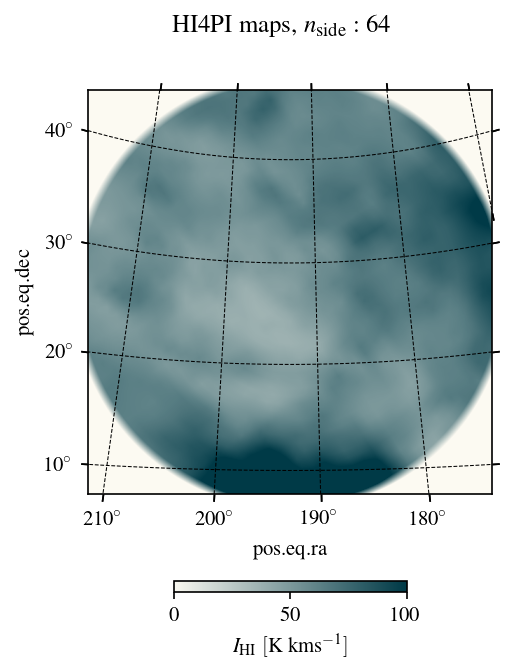

In [74]:
fig = plt.figure(figsize=(5, 5), dpi=150)

fig.suptitle(r"HI4PI maps, $n_{\rm side}: 64$")

ax = fig.add_subplot(projection='astro degrees zoom', center=center, radius=radius)
ax.grid(linestyle='--', linewidth=0.5, color='k')
img = ax.imshow_hpx((I_HI4PI_ma, Galactic()),  cmap='lin blu', vmin=0, vmax=100)
img.cmap.set_bad('w', alpha=0)

cb = plt.colorbar(img, orientation='horizontal', shrink=0.4)
cb.ax.xaxis.set_ticks([0, 50, 100])
cb.solids.set_edgecolor('face')
cb.set_label(r"$I_{\rm HI}~[\rm K~kms^{-1}]$")

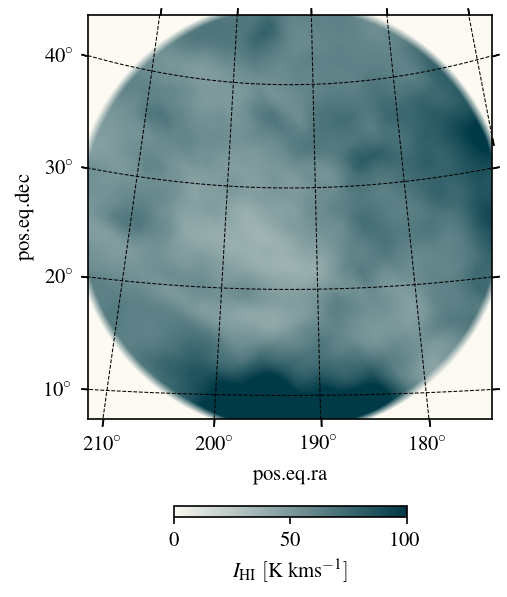

In [75]:
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = fig.add_subplot(projection='astro degrees zoom', center=center, radius=radius)
ax.grid(linestyle='--', linewidth=0.5, color='k')
img = ax.imshow_hpx((I_HI4PI_ma, Galactic()),  cmap='lin blu', vmin=0, vmax=100)
img.cmap.set_bad('w', alpha=0)

cb = plt.colorbar(img, orientation='horizontal', shrink=0.4)
cb.ax.xaxis.set_ticks([0, 50, 100])
cb.solids.set_edgecolor('face')
cb.set_label(r"$I_{\rm HI}~[\rm K~kms^{-1}]$")

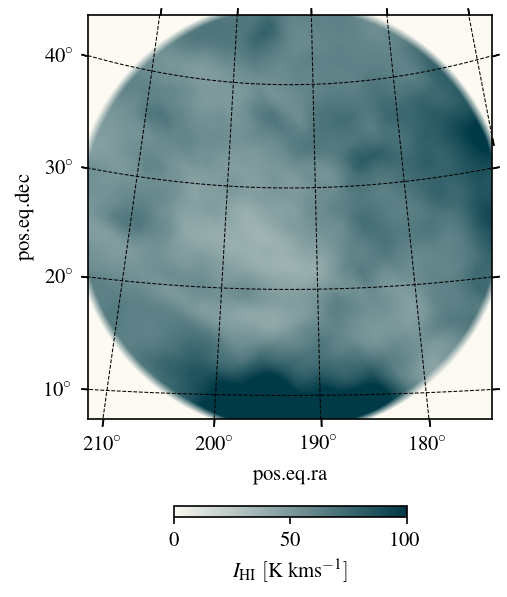

In [76]:
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = fig.add_subplot(projection='astro degrees zoom', center=center, radius=radius)
ax.grid(linestyle='--', linewidth=0.5, color='k')
img = ax.imshow_hpx((I_HI4PI_ma, Galactic()),  cmap='lin blu', vmin=0, vmax=100)
img.cmap.set_bad('w', alpha=0)

cb = plt.colorbar(img, orientation='horizontal', shrink=0.4)
cb.ax.xaxis.set_ticks([0, 50, 100])
cb.solids.set_edgecolor('face')
cb.set_label(r"$I_{\rm HI}~[\rm K~kms^{-1}]$")

## Create clustering dataset from positions and intensity

In [86]:
vecs = hp.pix2vec(nside, query)

In [87]:
X = np.vstack((*vecs, I_HI4PI_ma.compressed())).transpose()
print(X.shape)

(1512, 4)


## Plot one-dimensional histogram of pixel values in patch

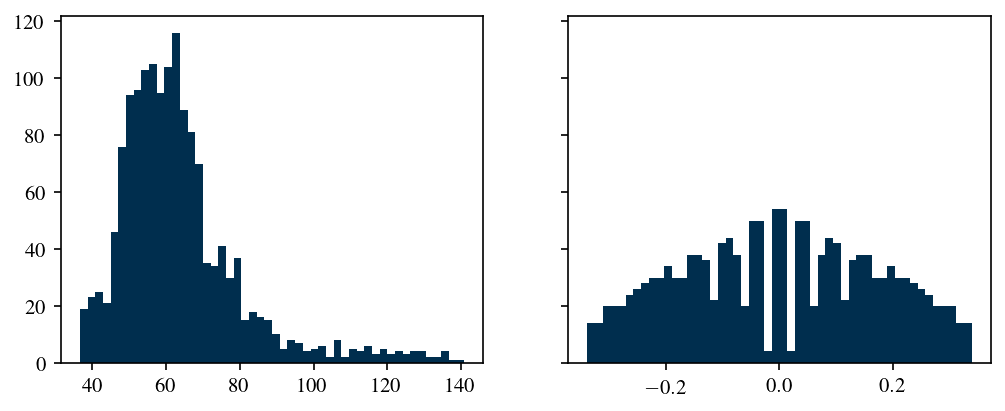

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150, sharey=True)
axes[0].hist(X[:, -1], bins=50);
axes[1].hist(X[:, 1], bins=50);
ax.set_ylabel('Frequency')
ax.set_xlabel(r'$I_{\rm HI}~[K~km^{-1}]$')
plt.show()

# Clustering in 1-D

Now we'll apply different clustering algorithms in one dimension

## $k$-means in 1-D

In [99]:
max_n_clust = 8
nclusters = list(range(2, max_n_clust + 1))
kmeans_predictions = {}

In [100]:
from copy import deepcopy

for n in nclusters:
    dataset = deepcopy(X[:, [-1]])
    dataset = StandardScaler().fit_transform(dataset)
    # create clustering estimator
    two_means = cluster.MiniBatchKMeans(n_clusters=n)
    arr = ma.masked_all(npix)
    arr.set_fill_value(np.nan)
    arr[query] = two_means.fit_predict(X)
    kmeans_predictions[f"{n}"] = arr

In [101]:
def plot_n_clusters(n_clusters):
    subplot_kws = {
        'projection': 'astro degrees zoom',
        'center': center,
        'radius': radius
    }
    pred = kmeans_predictions[f"{n_clusters}"]
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), dpi=150, subplot_kw=subplot_kws, sharey=True)
    plt.suptitle(f"$k$-means for {n_clusters} clusters")
    ax1.grid(linestyle='--', linewidth=0.5, color='k')
    ax2.grid(linestyle='--', linewidth=0.5, color='k')
    img1 = ax1.imshow_hpx((I_HI4PI_ma.filled(np.nan), Galactic()),  cmap='lin blu', vmin=0, vmax=70)
    img2 = ax2.imshow_hpx((pred.filled(np.nan), Galactic()),  cmap='lin blu', vmin=0, vmax=n_clusters)
    img1.cmap.set_bad('k', alpha=0.2)
    img2.cmap.set_bad('k', alpha=0.2)
    cb = plt.colorbar(img1, orientation='horizontal', shrink=0.4, ax=ax1)
    cb.ax.xaxis.set_ticks([0, 30, 70])
    cb.solids.set_edgecolor('face')
    cb = plt.colorbar(img2, orientation='horizontal', shrink=0.4, ax=ax2)
    cb.solids.set_edgecolor('face')
    cb.ax.xaxis.set_ticks(np.arange(0, n_clusters + 1))
    return 

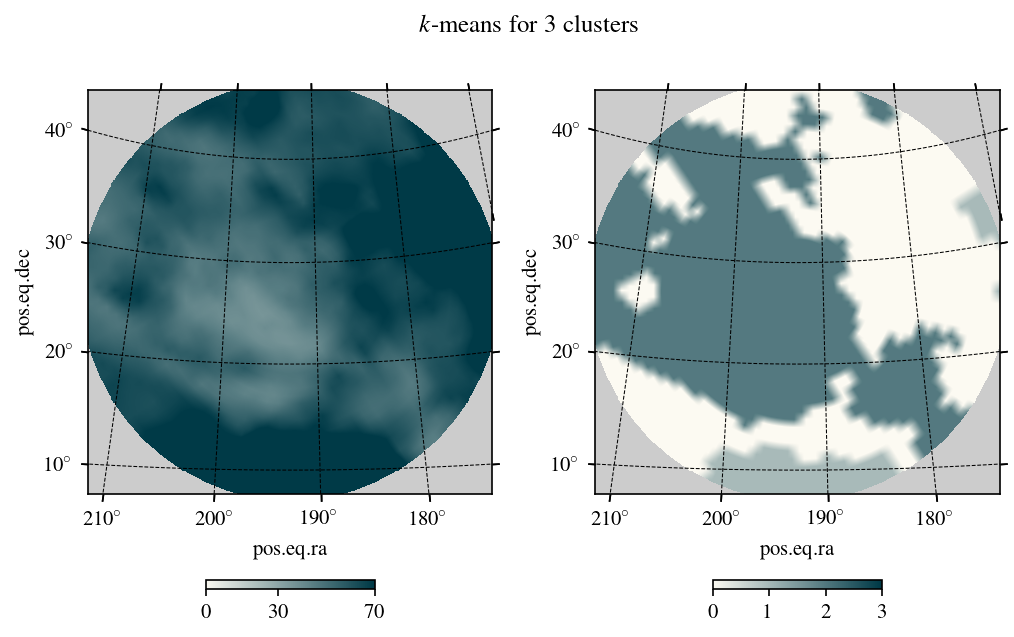

In [102]:
plot_n_clusters(3)

In [104]:
display_nclust = widgets.IntSlider(min=2, max=8)
out = widgets.interactive_output(plot_n_clusters, {'n_clusters': display_nclust})
widgets.HBox([widgets.VBox([display_nclust]), out])

## Gaussian Mixture Model

In [99]:
from copy import deepcopy
from sklearn import mixture

ncomponents = 6

dataset = deepcopy(X[:, [-1]])
dataset = StandardScaler().fit_transform(dataset)

arr = ma.masked_all(npix)
arr.set_fill_value(np.nan)
gmm = mixture.GaussianMixture(n_components=ncomponents, covariance_type="tied")
arr[query] = gmm.fit_predict(dataset)

<Figure size 640x480 with 0 Axes>

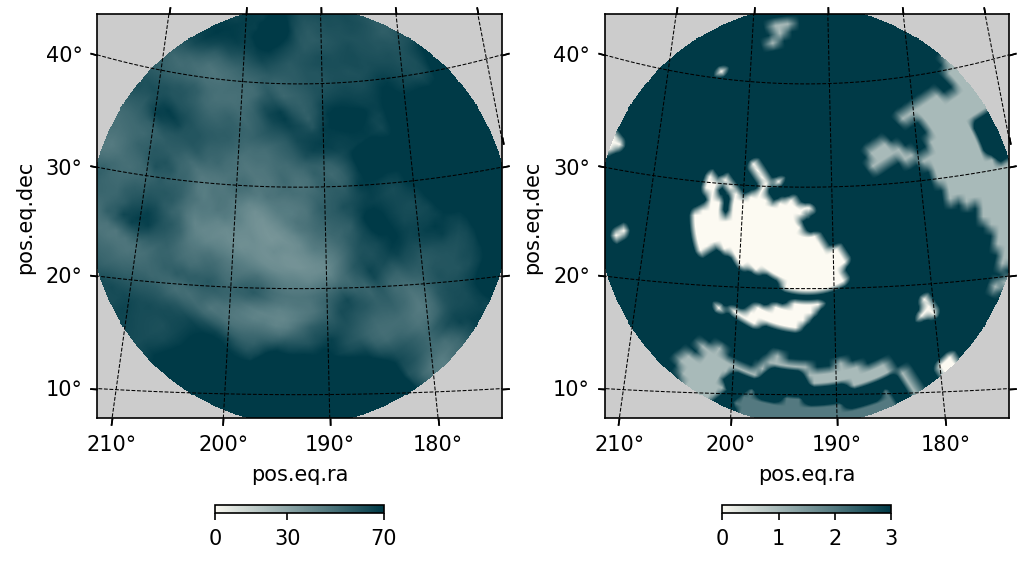

In [100]:
plt.suptitle(f"$k$-means for {ncomponents} components")
 
subplot_kws = {
    'projection': 'astro degrees zoom',
    'center': center,
    'radius': radius
}
    
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), dpi=150, subplot_kw=subplot_kws, sharey=True)

ax1.grid(linestyle='--', linewidth=0.5, color='k')
ax2.grid(linestyle='--', linewidth=0.5, color='k')
img1 = ax1.imshow_hpx((I_HI4PI_ma.filled(np.nan), Galactic()),  cmap='lin blu', vmin=0, vmax=70)
img2 = ax2.imshow_hpx((arr.filled(np.nan), Galactic()),  cmap='lin blu', vmin=0, vmax=3)
img1.cmap.set_bad('k', alpha=0.2)
img2.cmap.set_bad('k', alpha=0.2)
cb = plt.colorbar(img1, orientation='horizontal', shrink=0.4, ax=ax1)
cb.ax.xaxis.set_ticks([0, 30, 70])
cb.solids.set_edgecolor('face')
cb = plt.colorbar(img2, orientation='horizontal', shrink=0.4, ax=ax2)
cb.solids.set_edgecolor('face')
cb.ax.xaxis.set_ticks(np.arange(0, 3 + 1))

# Clustering in N- D 


We now add spatial information to label the points. This is a little ambiguous on the sphere, as the distance between points can be calculated in different ways. The natual way would be to calculate the geodesic distance between points on the surface. This would be quite slow, and does not have a simple implementation currently. What has been done previously in the literature is to calculate the unit-vector corresponding to the position of a point on the unit sphere. The three Cartesian components of this point can then be scaled by some factor, $\zeta$, and added as three features to the map value at that point:

\begin{equation}
\chi = \left(\frac{x_1}{\zeta}, \frac{x_2}{\zeta}, \frac{x_3}{\zeta}, I_{\rm HI}\right)
\end{equation}

### Mean-shift in multiple dimensions


In [85]:
predictions = {}
for zeta_idx in np.linspace(-1, 1, 5):
    zeta = 10 ** zeta_idx
    dataset = deepcopy(X)
    dataset = StandardScaler().fit_transform(dataset)
    dataset[:, 1:] = dataset[:, 1:] / zeta
    bandwidth = cluster.estimate_bandwidth(dataset, quantile=0.2)
    mean_shift = cluster.MeanShift(bin_seeding=True, bandwidth=bandwidth, n_jobs=8, cluster_all=False)
    prediction = ma.masked_all(npix)
    prediction.set_fill_value(np.nan)
    prediction[query] = mean_shift.fit_predict(dataset)
    predictions[f"{zeta}"] = prediction

In [86]:
def plot_mean_shift(zeta_idx):
    center = SkyCoord(l=0. * u.deg, b=90. * u.deg, frame=Galactic()).icrs
    subplot_kws = {
        'projection': 'astro degrees zoom',
        'center': center,
        'radius': radius
    }
    prediction = predictions[f"{10 ** zeta_idx}"]
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), dpi=150, subplot_kw=subplot_kws, sharey=True)
    plt.suptitle(f"Mean-shift, $\\zeta = 10^{{{zeta_idx:.02f}}}$")
    ax1.grid(linestyle='--', linewidth=0.5, color='k')
    ax2.grid(linestyle='--', linewidth=0.5, color='k')
    img1 = ax1.imshow_hpx((I_HI4PI_ma.filled(np.nan), Galactic()),  cmap='lin blu', vmin=0, vmax=70)
    img2 = ax2.imshow_hpx((prediction.filled(np.nan), Galactic()),  cmap='lin blu')
    img1.cmap.set_bad('k', alpha=0.2)
    img2.cmap.set_bad('k', alpha=0.2)
    cb = plt.colorbar(img1, orientation='horizontal', shrink=0.4, ax=ax1)
    cb.ax.xaxis.set_ticks([0, 35, 70])
    cb.solids.set_edgecolor('face')
    cb = plt.colorbar(img2, orientation='horizontal', shrink=0.4, ax=ax2)
    cb.solids.set_edgecolor('face')
    return 

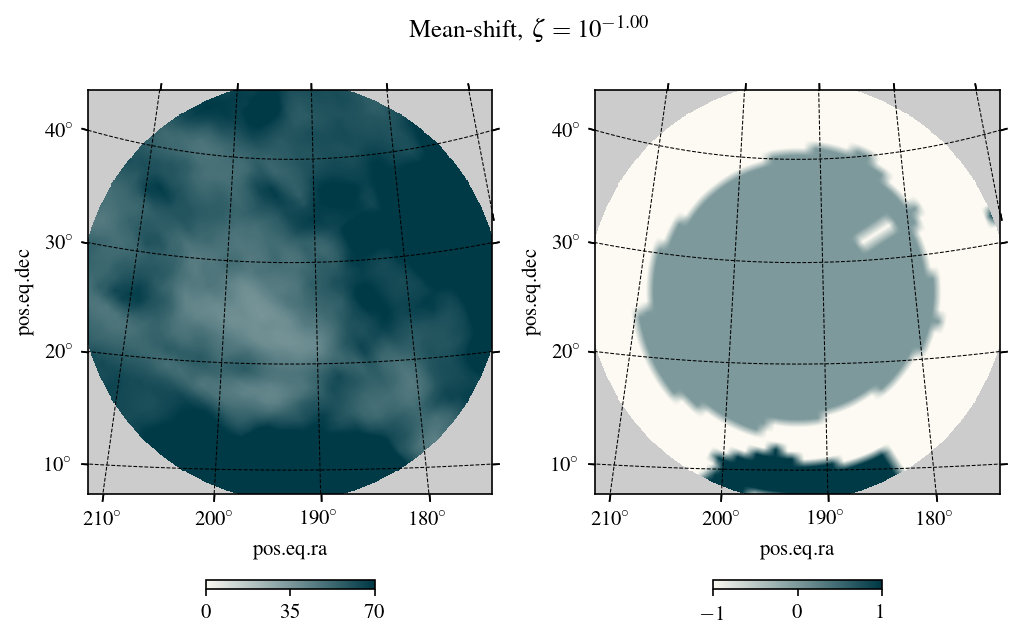

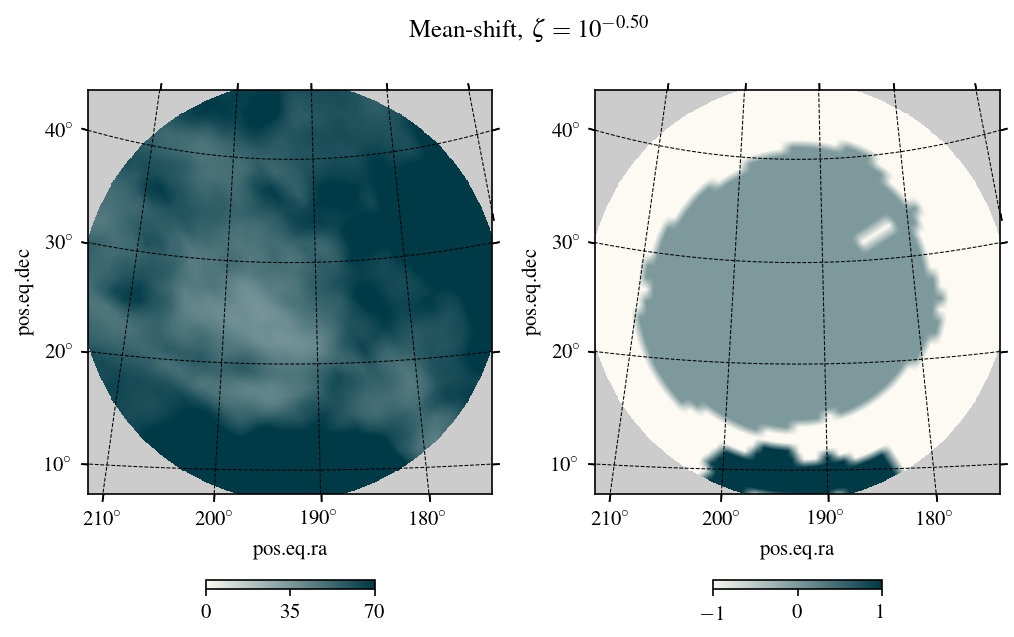

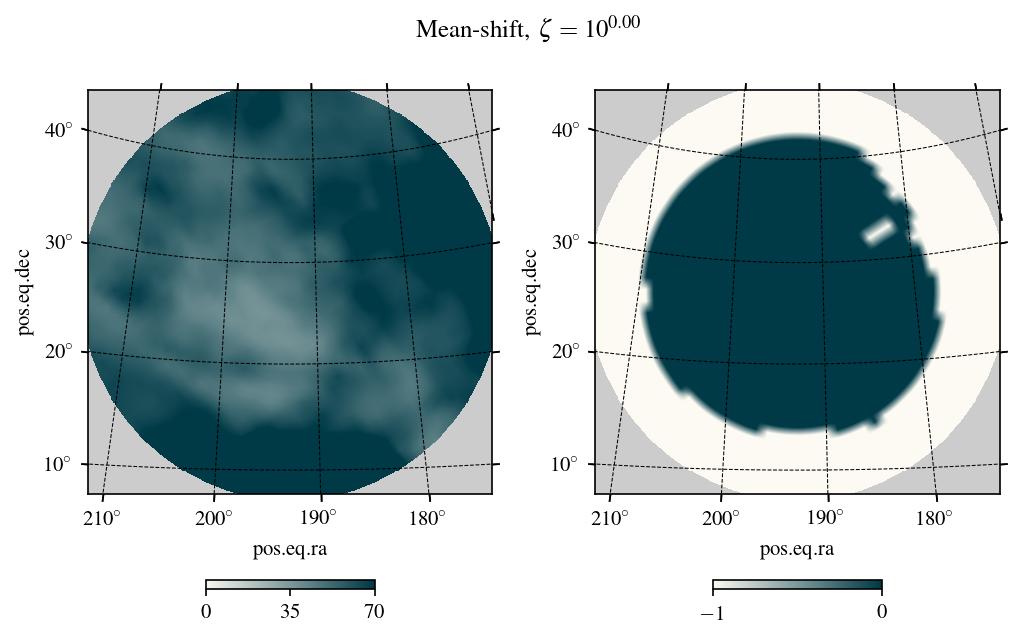

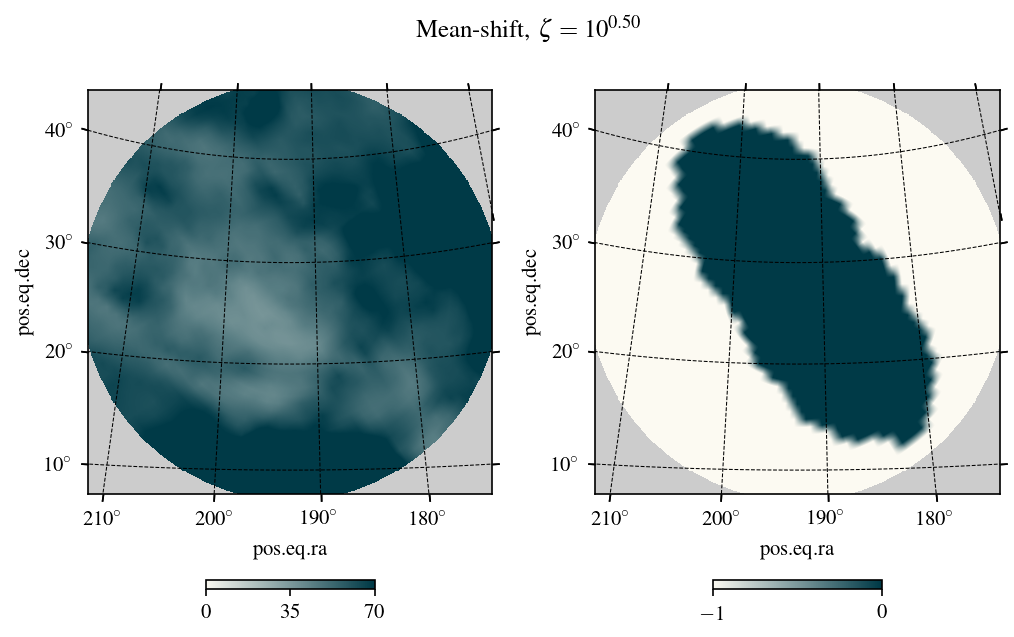

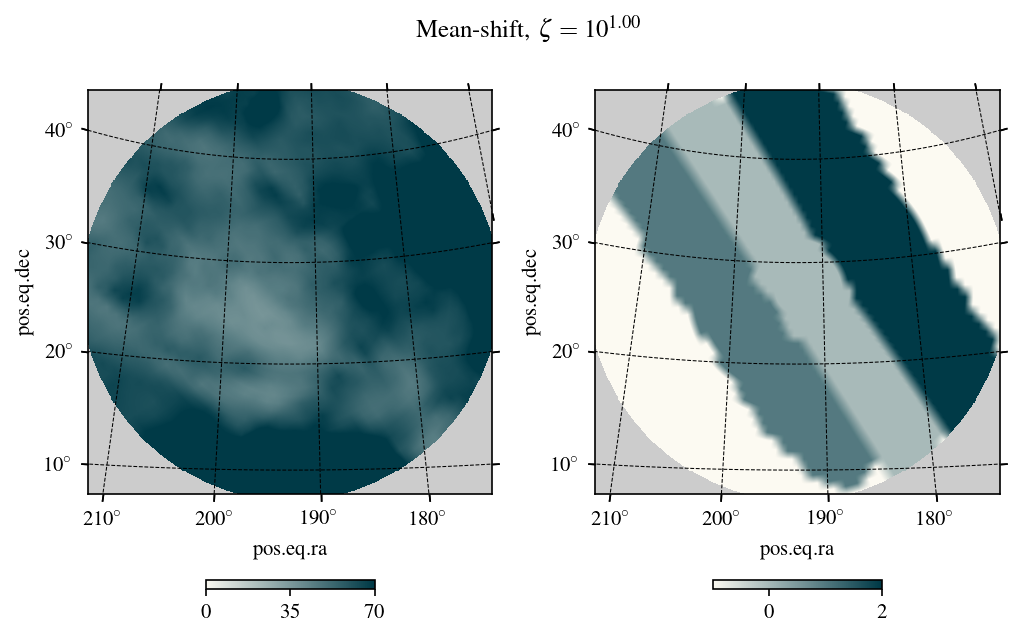

In [87]:
for i in np.linspace(-1, 1, 5):
    plot_mean_shift(i)

# Multi-velocity data

## Read in multi-velocity HI observations

In [1]:
import xarray as xr

In [10]:
IHI = xr.open_dataset(root / "IHI_v_nside_0064.cdf")

## Plot all velocity channels in patch

## Mean-shift with velocity dimension

Let's try mean-shift now including the velocity dimension. We first try on a subset of the velocity channels.

In [22]:
query = hp.query_strip(64, np.radians(0), np.radians(20))

IHI['IHI_v'].sel(healpix_index=query).values.shape

(1512, 41)

In [29]:
IHI['logIHI_v'] = np.log(IHI['IHI_v'])

/global/homes/b/bthorne/anaconda3/envs/h1/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [19]:
query

array([     0,      1,      2, ..., 379317, 379318, 379319])

ValueError: x and y must be the same size

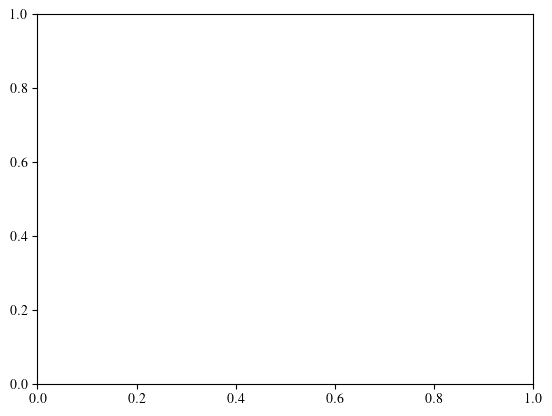

In [23]:
fig, ax = plt.subplots(ncols=1)
ax.scatter(IHI.channel_center, IHI['IHI_v'].sel(healpix_index=query).values)

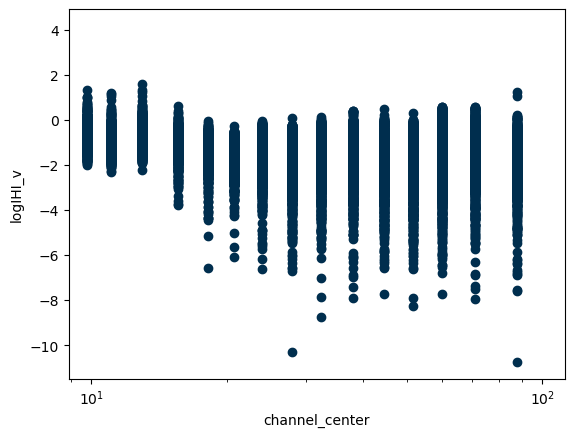

In [42]:
plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(ncols=1)
IHI.sel(healpix_index=query).transpose('channel_center', 'healpix_index').plot.scatter(x='channel_center', y='logIHI_v', ax=ax)
ax.set_xscale('log')


In [32]:
print(IHI.channel_center)

<xarray.DataArray 'channel_center' (channel_center: 41)>
array([-83.632975, -66.886225, -55.936375, -47.562975, -40.477825, -34.036725,
       -28.239775, -23.730975, -19.866375, -16.645825, -14.069375, -11.492975,
        -8.91655 ,  -6.984205,  -5.695995,  -4.407775,  -3.119565,  -1.831345,
        -0.543135,   0.745082,   2.033295,   3.321515,   4.609725,   5.897945,
         7.186155,   8.474375,   9.762585,  11.050825,  12.983125,  15.559525,
        18.136025,  20.712425,  23.932925,  27.797625,  32.306325,  38.103325,
        44.544375,  51.629575,  60.002975,  70.952775,  87.699625])
Coordinates:
  * channel_center  (channel_center) float64 -83.63 -66.89 -55.94 ... 70.95 87.7


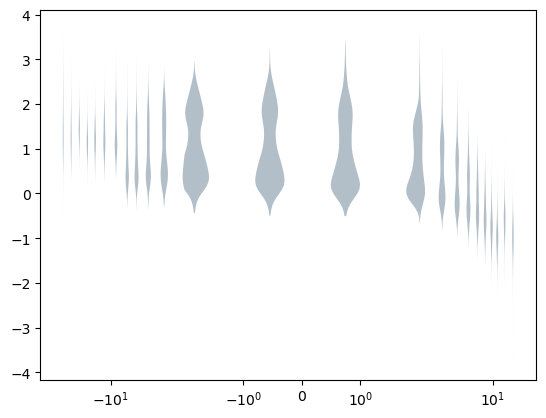

In [62]:
fig, ax = plt.subplots(1, 1)
ax.violinplot(IHI['logIHI_v'].sel(healpix_index=query).transpose('channel_center', 'healpix_index'), IHI.channel_center.values, points=40, showextrema=False)
ax.set_xscale('symlog')

In [54]:
IHI['IHI_v'].sel(healpix_index=query).transpose('channel_center', 'healpix_index').values.shape

(41, 1512)

In [56]:
IHI.channel_center.values.shape

(41,)

In [ ]:
predictions = {}
zeta = 10 ** 0.
dataset = deepcopy(IHI['logIHI_v'].values)
dataset = StandardScaler().fit_transform(dataset)
dataset[:, 1:] = dataset[:, 1:] / zeta
bandwidth = cluster.estimate_bandwidth(dataset, quantile=0.2)
mean_shift = cluster.MeanShift(bin_seeding=True, bandwidth=bandwidth, n_jobs=8, cluster_all=False)
prediction = ma.masked_all(npix)
prediction.set_fill_value(np.nan)
prediction[query] = mean_shift.fit_predict(dataset)
predictions[f"{zeta}"] = prediction